In [4]:
import pandas as pd
import os
import os.path as osp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm


In [5]:
# 데이터 불러오기
train = pd.read_csv('sample_data/housing_train.csv')
test = pd.read_csv('sample_data/housing_test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


In [6]:
train.shape

(1350, 14)

In [7]:
# 중복 제거
train = train.drop_duplicates()

In [8]:
# 결측치 여부
train.isnull().sum()

Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
target            0
dtype: int64

In [9]:
# 데이터형 확인
train.dtypes
test.dtypes

Overall Qual       int64
Gr Liv Area        int64
Exter Qual        object
Garage Cars        int64
Garage Area        int64
Kitchen Qual      object
Total Bsmt SF      int64
1st Flr SF         int64
Bsmt Qual         object
Full Bath          int64
Year Built         int64
Year Remod/Add     int64
Garage Yr Blt      int64
dtype: object

In [11]:
# 이산화
train.reset_index(inplace=True)
test.reset_index(inplace=True)

kind = ['Exter Qual', 'Kitchen Qual', 'Bsmt Qual']
Qual = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

def disc(df):
  for k in range(0,3):
     for q in range(0,6):
       df = df.replace({kind[k]:{Qual[q]:q}})
  return df

train = disc(train)
test = disc(test)

In [14]:
# 이상치 대체 1)
train[train['Garage Yr Blt'] > 2022]
train['Garage Yr Blt'] = np.where(train['Garage Yr Blt'] > 2021, 2007, train['Garage Yr Blt'])

In [15]:
# 이상치 대체 2,3,4)

# Full Bath - Gr Liv Area 상관관계 | Full Bath == 0
train['Full Bath'] = np.where((train['Full Bath'] == 0), (train['Gr Liv Area']/875).astype(int), train['Full Bath'])
# Year Built' > Garage Yr Blt
train['Garage Yr Blt'] = np.where(train['Year Built'] > train['Garage Yr Blt'], train['Year Built']+5, train['Garage Yr Blt'])
# Year Remod/Add < Year Built
train['Year Remod/Add'] = np.where(train['Year Remod/Add'] < train['Year Built'], train['Year Remod/Add']+12, train['Year Remod/Add'])

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x=train['Year Built'], y=train['target'])
plt.figure(figsize=(20,10))
plt.scatter(x=train['Garage Area'], y=train['target'])
plt.figure(figsize=(20,10))
plt.scatter(x=train['Year Remod/Add'], y=train['target'])
plt.figure(figsize=(20,10))
plt.scatter(x=train['Garage Yr Blt'], y=train['target'])

In [17]:
train[['Overall Qual','Exter Qual','Kitchen Qual','Bsmt Qual']].describe()

,Overall Qual,Exter Qual,Kitchen Qual,Bsmt Qual
count,1349.000000,1349.000000,1349.000000,1349.000000
mean,6.208302,3.426242,3.556709,3.606375
std,1.338338,0.573856,0.663209,0.694395
min,2.000000,2.000000,2.000000,1.000000
25%,5.000000,3.000000,3.000000,3.000000
50%,6.000000,3.000000,3.000000,4.000000
75%,7.000000,4.000000,4.000000,4.000000
max,10.000000,5.000000,5.000000,5.000000


In [19]:
# 동화책님 참조
# kitchen Qual / Bsmt Qual / Exter Qual 병합
# 1개 Car Area = Garage Area / Garage Cars
# 1층 외 층 여부

def drived_var(df):
  df['EKB_Qual'] = df[["Exter Qual", "Kitchen Qual", "Bsmt Qual"]].sum(axis=1)
  df['Car Area'] = df['Garage Area']/df['Garage Cars']
  df['A_flr SF'] = df['Gr Liv Area'] - df['1st Flr SF']
  df['A_flr'] = (df['A_flr SF']).apply(lambda x : 1 if x > 0 else 0)
  return df

train = drived_var(train)
test = drived_var(test)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb475a6110>,
      dtype=object)

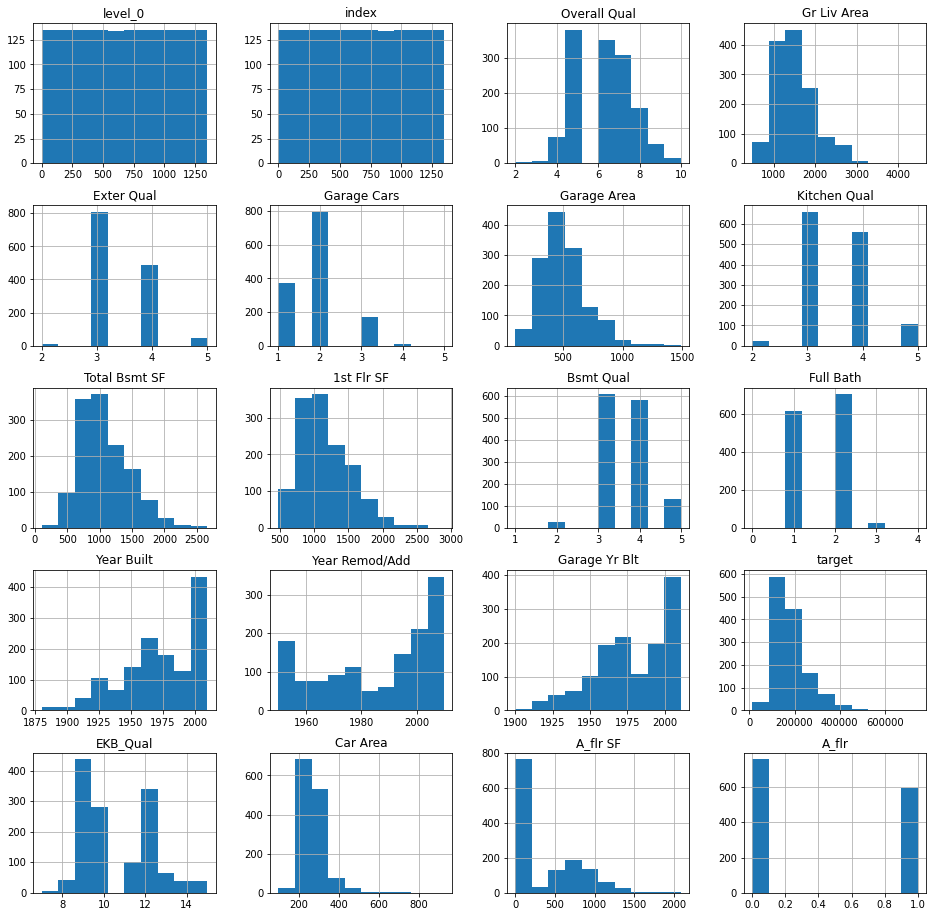

In [20]:
train.hist(figsize=(16, 16))

In [21]:
# 로그 변환
train_ = train.copy()
train['target'] = np.log1p(train['target'])

In [ ]:
# 분포 확인
f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(train['target'])

In [23]:
# train Data -> 표준화
from sklearn.preprocessing import StandardScaler, RobustScaler
Scaler = RobustScaler()
df = train[['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt']]

Scaler.fit(df)
Scaled_df = Scaler.transform(df)
Scaled_df = pd.DataFrame(data = Scaled_df)
train_ = train.copy()
c = 0
for i in df.columns:  
  train[i] = Scaled_df[c]
  c += 1

In [26]:
# test Data -> 표준화
from sklearn.preprocessing import StandardScaler, RobustScaler
Scaler = StandardScaler()
df = test[['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt']]

Scaler.fit(df)
Scaled_df = Scaler.transform(df)
Scaled_df = pd.DataFrame(data = Scaled_df)
test_ = test.copy()
c = 0
for i in df.columns:  
  test[i] = Scaled_df[c]
  c += 1

In [ ]:
test[['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt']]

In [ ]:
train.describe()

In [28]:
# X / Y 분할
X_train = train.drop(columns =['target'])
y_train = train['target']

# 나중에 array로 변경 예정
x = train.drop(['target'], axis = 1)
y = train['target']

In [29]:
# mae를 이용한 새로운 회귀성능지표
def NMAE(real, pred):
    mae = np.mean(np.abs(real-pred))
    score = mae / np.mean(np.abs(real))
    return score

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor

#GridSearchCV by Dacon
from sklearn.model_selection import GridSearchCV

params = []
params_rf = {'n_estimators' : [90, 150, 200, 1000],
            'min_samples_split' : [1,2,3,4]}
rf = RandomForestRegressor()
params_gbr = {'loss' : ['huber', 'quantile'],
             'learning_rate':[0.05,0.07,0.09,0.11,0.13,0.15],
             'n_estimators':[60,80,90,110,120,140,150]}
gbr = GradientBoostingRegressor()
params_gbr = {'loss' : ['huber', 'quantile'],
             'learning_rate':[0.05,0.07,0.09,0.11],
             'n_estimators':[60,80,90,120,1000]}

lso = Lasso()
params_lso = {'alpha' : [0.0003, 0.0005, 0.001]}

xgb = XGBRegressor()
params_xgb = {'learning_rate':[0.05,0.07,0.09,0.11,0.13,0.15],
             'n_estimators' : [40,70,100,250,500,1000]}

params.append(params_rf)
params.append(params_gbr)
params.append(params_lso)
params.append(params_xgb)

estimators = []
estimators.append(rf)
estimators.append(gbr)
estimators.append(lso)
estimators.append(xgb)


from tqdm.auto import tqdm
def gridSearchCV(models,params):
    best_models=[]
    for i in tqdm(range(0,len(models))):
        model_grid = GridSearchCV(models[i], params[i],n_jobs = -1, verbose=1, cv=5)
        model_grid.fit(X_train,y_train)
        best_models.append(model_grid.best_estimator_)
    return best_models

best_model_list = gridSearchCV(estimators,params)
best_model_list

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[08:16:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[RandomForestRegressor(min_samples_split=4, n_estimators=1000),
 GradientBoostingRegressor(learning_rate=0.07, loss='huber', n_estimators=90),
 Lasso(alpha=0.0005),
 XGBRegressor(learning_rate=0.09, n_estimators=70)]

In [32]:
from sklearn.ensemble import VotingRegressor

best_models = [
    ('rf_reg', RandomForestRegressor(random_state = 11,
                                 n_estimators = 1000,
                                 min_samples_split = 4)),
    
    ('gb_reg', GradientBoostingRegressor(learning_rate=0.07,
                                       loss='huber',
                                       n_estimators=80)),
    ('lso_reg', Lasso(alpha=0.005)),
    ('xgb_reg', XGBRegressor(learning_rate=0.09, n_estimators=70))
]


VR = VotingRegressor(estimators = best_models)

In [33]:
X_test = np.array(test)

x = np.array(x)
y = np.array(y)

from sklearn.model_selection import KFold
kfold = KFold(n_splits = 15, shuffle = True, random_state = 11)

nmae_mean= []
c = 0
rf_result = np.zeros(test.shape[0])

for train_idx, val_idx in kfold.split(x, y):

    x_train, x_val = x[train_idx], x[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    VR.fit(x_train, y_train)
    pred_rf = VR.predict(x_val)

    c += 1
    nmae = NMAE(np.expm1(y_val), np.expm1(pred_rf))

    print('교차 검증+앙상블{0}: {1}'.format(c, nmae))
    nmae_mean.append(nmae)
    rf_result += VR.predict(X_test)/10

print('=> 총 교차 검증 평균:', np.mean(nmae_mean)) 
rf_result

[08:16:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
교차 검증+앙상블1: 0.1098726863640191
[08:16:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
교차 검증+앙상블2: 0.10798673503837425
[08:16:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
교차 검증+앙상블3: 0.10102160049601182
[08:17:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
교차 검증+앙상블4: 0.08776256002835159
[08:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
교차 검증+앙상블5: 0.09304704312876652
[08:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
교차 검증+앙상블6: 0.08447590469117036
[08:17:38] WARNING: /workspace/src/objective/re

array([19.13949271, 17.40826   , 18.08232732, ..., 16.82118507,
       18.2317393 , 17.75079018])

In [35]:
sub = pd.read_csv('sample_data/sample_submission.csv')
# log 값 복원
sub['target'] = np.expm1(rf_result)
sub.to_csv(('submission.csv'), index=False) 